# Visualization-and-Solutions-for-Organizational-Improvement


**Made By:** *Neha Thakare*
    

### **Goal 1:** *Recognize the highest profitable types of jobs* - To survey the improvement of the organization on comparison of profitability of each job type.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.colors as colors


In [2]:
# Read all the csv files
landscaping_df = pd.read_csv('landscaping.csv')
employees_df = pd.read_csv('employees.csv')
calendar_df = pd.read_csv('calendar.csv')

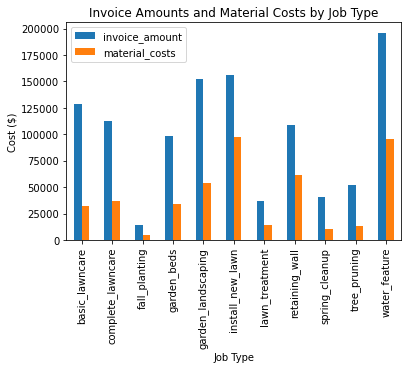

In [3]:
# Group the data by job type and sum the invoice amounts and material costs
df_grouped = landscaping_df.groupby('job_type').sum()[['invoice_amount', 'material_costs']]

# Create a stacked bar chart of invoice amounts and material costs by job type
df_grouped.plot(kind='bar', stacked=False)

# Set the title and axes labels
plt.title('Invoice Amounts and Material Costs by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Cost ($)')

# Show the plot
plt.show()


In above graph, as per your recomendation on project proposal, stacked bar was miss guiding the data, hence i replaced it with individual bar to repesent invoice amount and material cost as seperate entity.

#### Exploratory(Profits by Job Type) Visualization:

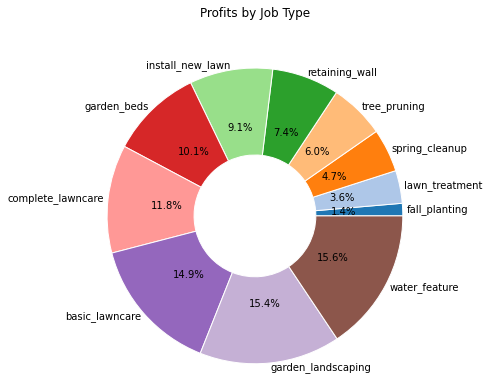

The most profitable job type is: water_feature
The least profitable job type is: fall_planting


In [4]:
# Convert 'start_date' and 'completion_date' columns to datetime data type
landscaping_df['start_date'] = pd.to_datetime(landscaping_df['start_date'])
landscaping_df['completion_date'] = pd.to_datetime(landscaping_df['completion_date'])

# Calculate the profit for each job type
landscaping_df['profit'] = landscaping_df['invoice_amount'] - landscaping_df['material_costs']

#Merge the employees_df with landscaping_df
merged_df = pd.merge(landscaping_df, employees_df, how='left', left_on='job_id', right_on='employee_id')

# Calculate the total cost per hour
merged_df['total_cost_per_hour'] = merged_df['profit'] / (merged_df['completion_date'] - merged_df['start_date']).dt.total_seconds() / 3600

# Group the data by job type and sum the profits
profits_by_type = merged_df.groupby('job_type')['profit'].sum().sort_values()

# Group the data by job type and sum the profits
profits_by_type_per_hour = merged_df.groupby('job_type')['total_cost_per_hour'].sum().sort_values()

# Define a pre-defined color map
cmap = plt.get_cmap('tab20')

# Define the number of job types
num_job_types = len(profits_by_type)

# Create a list of colors with lighter shades
colors_list = [colors.rgb2hex(cmap(i)[:3] + (0.5,)) for i in range(num_job_types)]

# Create a custom color map
cmap_light = colors.ListedColormap(colors_list)

# Create a pie chart of the profits by job type using the custom color map
plt.pie(profits_by_type.values, labels=profits_by_type.index, autopct='%1.1f%%', radius=1.7, labeldistance=1.03, wedgeprops=dict(width=1, edgecolor='w'), colors=cmap_light(range(num_job_types)))
plt.title('Profits by Job Type', pad=90)
plt.show()

# Find the job type with the highest profit
most_profitable_type = profits_by_type.idxmax()
print('The most profitable job type is:', most_profitable_type)

# Find the job type with the lowest profit
least_profitable_type = profits_by_type.idxmin()
print('The least profitable job type is:', least_profitable_type)


#### Interactive Visualization – ‘Correlation Matrix Heatmap’:

In [5]:
# Calculate the profitability of each job type
profitability_df = merged_df.groupby('job_type')['total_cost_per_hour'].mean().reset_index()

# Merge the profitability_df with the original landscaping_df to include job satisfaction ratings
merged_df = pd.merge(landscaping_df, profitability_df, how='left', on='job_type')

# Drop rows where 'total_cost_per_hour' is NaN
merged_df.dropna(subset=['total_cost_per_hour'], inplace=True)

# Drop irrelevant columns
merged_df.drop(['job_id', 'customer_id'], axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = merged_df.corr()

# Create a dataframe that only contains the correlation matrix values
corr_data = corr_matrix.stack().reset_index()

# Create an interactive heatmap with Plotly
fig = px.imshow(corr_matrix.values,
                
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale='RdBu',
                zmin=-1, zmax=1)
fig.update_layout(title='Correlation Matrix Heatmap')
fig.show()

### **Goal 2:** *Optimize employee allocation - To allocate the employes appropriately during peak or busy periods and diminish costs during slower or dead periods.*


In [6]:
# Load the CSV files into dataframes
landscaping_df = pd.read_csv('landscaping.csv')
employees_df = pd.read_csv('employees.csv')
calendar_df = pd.read_csv('calendar.csv')

# Merge the landscaping and employees dataframes on the employee_id field
merged_df = pd.merge(landscaping_df, employees_df, how='left', left_on='job_id', right_on='employee_id')


# Merge the merged dataframe with the calendar dataframe on the start_date and date fields
merged_df = pd.merge(merged_df, calendar_df, left_on='start_date', right_on='date')

#Convert object to datetime
merged_df['completion_date'] = pd.to_datetime(merged_df['completion_date'])
merged_df['start_date'] = pd.to_datetime(merged_df['start_date'])

# Calculate the total hourly wages for each employee based on the number of hours worked on each job
merged_df['total_hours'] = (merged_df['completion_date'] - merged_df['start_date']).dt.total_seconds() / 3600
emp_wages = merged_df.groupby('employee_id').agg(total_wages=('total_hours', 'sum'), hourly_wage=('hourly_wage', 'first')).reset_index()
emp_wages['total_wages'] = emp_wages['total_wages'] * emp_wages['hourly_wage']

# Calculate the total revenue for each day by summing up the invoice amount for all completed jobs on that day
revenue = merged_df.loc[merged_df['completion_date'].notnull()].groupby('date').agg(total_revenue=('invoice_amount', 'sum')).reset_index()

# Calculate the total material costs and total hourly wages for each day
costs_df = merged_df.groupby('date').agg(total_material_costs=('material_costs', 'sum'), total_hourly_wages=('employee_id', lambda x: emp_wages.loc[emp_wages['employee_id'].isin(x)]['total_wages'].sum())).reset_index()

# Calculate the profit for each day by subtracting the total material costs and total hourly wages from the total revenue
profit_df = pd.merge(revenue, costs_df, on='date')
profit_df['profit'] = profit_df['total_revenue'] - profit_df['total_material_costs'] - profit_df['total_hourly_wages']

# Calculate the average profit for each month
profit_df['month'] = pd.to_datetime(profit_df['date']).dt.month
avg_profit_df = profit_df.groupby('month').agg(avg_profit=('profit', 'mean')).reset_index()

# Identify the months with the highest average profit
busiest_months = avg_profit_df.nlargest(3, 'avg_profit')['month']

# Allocate more resources during the busiest months
resources_allocation = {}
for month in busiest_months:
    resources_allocation[month] = 'Increase Resources'

print("FOLLOWING ARE THE BUSIEST MONTHS IN THE YEAR, WHERE RESOURCES SHOULD BE ALLOCATED MORE THAN OTHER MONTHS :")
print(resources_allocation)


FOLLOWING ARE THE BUSIEST MONTHS IN THE YEAR, WHERE RESOURCES SHOULD BE ALLOCATED MORE THAN OTHER MONTHS :
{4: 'Increase Resources', 6: 'Increase Resources', 5: 'Increase Resources'}


#### Derived Data Type Visualization – ‘Average Profit Over Time’:

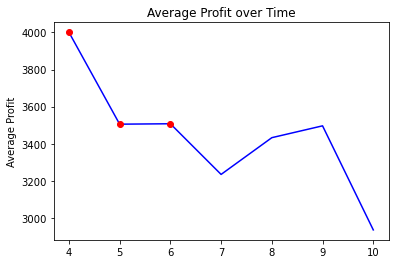

In [7]:
# Create a line plot of the average profit over time
plt.plot(avg_profit_df['month'], avg_profit_df['avg_profit'], color='blue')

# Add a label to the y axis
plt.ylabel('Average Profit')

# Highlight the busiest months by plotting them with a different color or style
busiest_months_highlight = avg_profit_df['month'].isin(busiest_months)
plt.plot(avg_profit_df.loc[busiest_months_highlight, 'month'], avg_profit_df.loc[busiest_months_highlight, 'avg_profit'], color='red', marker='o', linestyle='')

# Add a title to the plot
plt.title('Average Profit over Time')

# Show the plot
plt.show()